In [38]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# 2. Đọc file csv
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FinalProject_BA/NVL Historical Data.csv')

In [40]:
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df=df[::-1]
df1=df.reset_index()['Price']

In [41]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [42]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = int(len(df1)) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [43]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [44]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [45]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [46]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
18/18 [==============================] - 4s 87ms/step - loss: 0.0438 - val_loss: 0.0271
Epoch 2/100
18/18 [==============================] - 1s 80ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 3/100
18/18 [==============================] - 2s 84ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 4/100
18/18 [==============================] - 1s 67ms/step - loss: 8.1420e-04 - val_loss: 4.2487e-04
Epoch 5/100
18/18 [==============================] - 1s 48ms/step - loss: 4.6180e-04 - val_loss: 7.7963e-05
Epoch 6/100
18/18 [==============================] - 1s 48ms/step - loss: 4.2887e-04 - val_loss: 8.0817e-05
Epoch 7/100
18/18 [==============================] - 1s 48ms/step - loss: 4.1468e-04 - val_loss: 8.8633e-05
Epoch 8/100
18/18 [==============================] - 1s 47ms/step - loss: 3.9499e-04 - val_loss: 9.1446e-05
Epoch 9/100
18/18 [==============================] - 1s 47ms/step - loss: 3.8247e-04 - val_loss: 9.7873e-05
Epoch 10/100
18/18 [==============================] 

In [48]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)

7/7 [==============================] - 0s 15ms/step


In [49]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [50]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 16356.649784461535


In [51]:
x_input = test_data[len(test_data)-time_step:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

print(lst_output)


[[0.07958097010850906], [0.07825063169002533], [0.07663872838020325], [0.07485536485910416], [0.07295317947864532], [0.07095986604690552], [0.06889301538467407], [0.06676506996154785], [0.06458526104688644], [0.06236083805561066], [0.06009757146239281], [0.05780021473765373], [0.055472709238529205], [0.053118426352739334], [0.05074017867445946], [0.048340391367673874], [0.04592115059494972], [0.043484244495630264], [0.041031211614608765], [0.03856336325407028], [0.036081843078136444], [0.03358764573931694], [0.031081609427928925], [0.028564469888806343], [0.026036856696009636], [0.02349930815398693], [0.02095230482518673], [0.018396245315670967], [0.0158314760774374], [0.013258309103548527], [0.010677006095647812], [0.008087793365120888], [0.005490870214998722], [0.0028864163905382156], [0.00027458067052066326], [-0.002344502368941903], [-0.0049707042053341866], [-0.007603923790156841], [-0.010244065895676613], [-0.012891033664345741], [-0.015544752590358257], [-0.018205147236585617], 

In [52]:
future_predict = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))
future_predict

array([[16784.87094143],
       [16675.62887186],
       [16543.26581967],
       [16396.82314077],
       [16240.62328607],
       [16076.94036031],
       [15907.21885133],
       [15732.48048496],
       [15553.48329613],
       [15370.82257777],
       [15184.97217821],
       [14996.3224334 ],
       [14805.19699183],
       [14611.87269838],
       [14416.58051203],
       [14219.51957755],
       [14020.86120225],
       [13820.752221  ],
       [13619.31897295],
       [13416.66913697],
       [13212.8966262 ],
       [13008.08311753],
       [12802.29743978],
       [12595.60000939],
       [12388.04252445],
       [12179.66918837],
       [11970.51946303],
       [11760.62608034],
       [11550.01748957],
       [11338.71931035],
       [11126.75303255],
       [10914.13723997],
       [10700.88829857],
       [10487.02096833],
       [10272.54746634],
       [10057.47884347],
       [ 9841.82565347],
       [ 9625.59619405],
       [ 9408.79828491],
       [ 9191.43987962],


In [53]:
# Append the last 100 values of test_data to the beginning of y_pred
last_100_test_data = scaler.inverse_transform(test_data[-101:])
y_pred_with_test_data = np.append(last_100_test_data, y_pred)

In [54]:
print(y_pred_with_test_data.shape)
test_data.shape

(311,)


(311, 1)

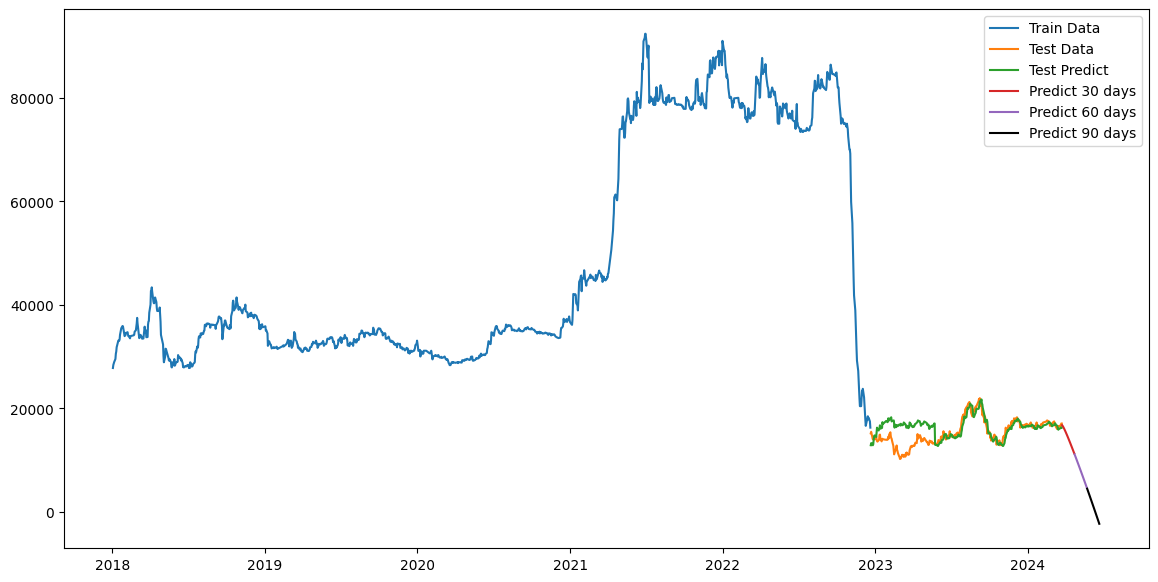

In [55]:
# Plot results
plt.figure(figsize=(14, 7))

# Plot train data
plt.plot(df['Date'][:train_size], scaler.inverse_transform(train_data), label='Train Data')

# Plot test data
plt.plot(df['Date'][train_size:], scaler.inverse_transform(test_data), label='Test Data')

# Plot test predict data with appended last 100 test data
plt.plot(df['Date'][train_size:train_size + len(y_pred_with_test_data)], y_pred_with_test_data, label='Test Predict')

# Plot future predictions
last_test_date = df['Date'].iloc[-1]
future_predict_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=30)
future_predict_dates_1 = pd.date_range(start=last_test_date + pd.Timedelta(days=31), periods=30)
future_predict_dates_2 = pd.date_range(start=last_test_date + pd.Timedelta(days=61), periods=30)

plt.plot(future_predict_dates, future_predict[0:30], label='Predict 30 days')
plt.plot(future_predict_dates_1, future_predict[30:60], label='Predict 60 days')
plt.plot(future_predict_dates_2, future_predict[60:90], label='Predict 90 days', color='black')
# Display the legend
plt.legend()

# Display the plot
plt.show()